# Mercari Price Prediction Challenge
Source: Kaggle https://www.kaggle.com/competitions/mercari-price-suggestion-challenge/overview

# Table of content
- 1. Business problem<br>
    - 1.1 About Mercari<br>
    - 1.2 Problem description<br>
    - 1.3 Data<br>
- 2. Exploratory Data Analysis<br>
    - 2.1 Basic Data Exploration<br>
    - 2.2 Analysing price<br>
        - 2.2.1 Visual Analysis<br>
        - 2.2.2 Statistical tests<br>
            - 2.2.2.1 Q-Q Plot<br>
            - 2.2.2.2 KS Test<br>
            - 2.2.2.3 Shapiro's Test<br>
    - 2.3 Analysing category_name<br>
        - 2.3.1 Treating null values<br>
        - 2.3.2 Preprocessing category_name<br>
        - 2.3.3 Visual Analysis<br>
    - 2.4 Analysing brand_name
        - 2.4.1 Treating null values
        - 2.4.2 Visual analysis
    - 2.5 Analysing item_description
        - 2.5.1 Treating null values
        - 2.5.2 Text preprocessing
        - 2.5.3 Analysing impact on price
        - 2.5.4 Feature engineering
    - 2.6 Analysing item_condition
    - 2.7 Analysing shipping
    - 2.7 Analysing name
        - 2.7.1 Preprocessing
        - 2.7.2 Analysing impact on price
        - 2.7.3 Feature engineering
- 3. Conclusion

# Business Problem

### About Mercari
Mercari is a Japanese e-commerce company. Their main product is the Mercari marketplace app, which allows users to buy and sell items quickly from their smartphones. The app is known for its ease of use and unique shipping system, which allows users to ship items anonymously from local convenience stores.

### Problem description
It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, a sweaters cost \\$335 and the other cost \\$9.99.<br>
Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.<br>
Mercari would like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.<br>
In this case study, we are expected to perform exploratory data analysis and come up with observations about trends and dependencies within the dataset.

### Data
The data is a tab-delimited file and contains the following columns

- **train_id** - the id of the listing
- **name** - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. \\$20) to avoid leakage. These removed prices are represented as [rm]
- **item_condition_id** - the condition of the items provided by the seller
- **category_name** - category of the listing
- **brand_name** - name of the brand
- **price** - the price that the item was sold for. This is the target variable. The unit is USD.
- **shipping** - 1 if shipping fee is paid by seller and 0 by buyer
- **item_description** - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

# Exploratory Data Analysis

In [34]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, ttest_ind
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kstest, shapiro
from scipy.stats import f_oneway
from scipy.stats import spearmanr

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

In [35]:
# reading data
# the file has a '.tsv' format
raw = pd.read_csv('data/train.tsv',sep='\t')

## Basic exploration

In [36]:
# shape
print(f"Number of rows: {raw.shape[0]}")
print(f"Number of columns: {raw.shape[1]}")

Number of rows: 1482535
Number of columns: 8


In [37]:
# first 5 rows
raw.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [38]:
# info
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [39]:
# describe
for data_type in list(set(raw.dtypes.values)):
    print(f"Description of the data for data type: {data_type}")
    display(raw.describe(include = str(data_type), exclude=None))
    print("-"*30)

Description of the data for data type: float64


,price
count,1.482535e+06
mean,2.673752e+01
std,3.858607e+01
min,0.000000e+00
25%,1.000000e+01
50%,1.700000e+01
75%,2.900000e+01
max,2.009000e+03


------------------------------
Description of the data for data type: object


,name,category_name,brand_name,item_description
count,1482535,1476208,849853,1482531
unique,1225273,1287,4809,1281426
top,Bundle,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,No description yet
freq,2232,60177,54088,82489


------------------------------
Description of the data for data type: int64


,train_id,item_condition_id,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,4.472744e-01
std,4.279711e+05,9.031586e-01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,0.000000e+00
50%,7.412670e+05,2.000000e+00,0.000000e+00
75%,1.111900e+06,3.000000e+00,1.000000e+00
max,1.482534e+06,5.000000e+00,1.000000e+00


------------------------------


In [40]:
# null values

# absolute null values
print(f"--- Absolute null values ---")
display(raw.isna().sum())
# percentage null values
print(f"--- Percentage null values ---")
display(np.round(raw.isna().sum()*100/raw.shape[0],2))

--- Absolute null values ---


train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

--- Percentage null values ---


train_id              0.00
name                  0.00
item_condition_id     0.00
category_name         0.43
brand_name           42.68
price                 0.00
shipping              0.00
item_description      0.00
dtype: float64

In [41]:
# duplicates

# overall duplicates
print(f"--- Overall duplicates: {raw.duplicated().sum()}")
# column wise duplicates
print(f"--- Duplicates in train_id: {raw['train_id'].duplicated().sum()}")
print(f"--- Duplicates in name: {raw['name'].duplicated().sum()}")

--- Overall duplicates: 0
--- Duplicates in train_id: 0
--- Duplicates in name: 257262


In [42]:
# number of unique values
cols = ['name', 'item_condition_id', 'category_name', 'brand_name', 'shipping']
for col in cols:
    print(f"Unique values in {col} = {raw[col].nunique()}")

Unique values in name = 1225273
Unique values in item_condition_id = 5
Unique values in category_name = 1287
Unique values in brand_name = 4809
Unique values in shipping = 2


In [43]:
# unique values
cols = ['item_condition_id', 'shipping']
for col in cols:
    print(f"{col}: {raw[col].unique()}")

item_condition_id: [3 1 2 4 5]
shipping: [1 0]


In [44]:
# value counts for top 5 values
cols = ['name', 'item_condition_id', 'category_name', 'brand_name', 'shipping']
for col in cols:
    print(f"--- {col} ---")
    print(f"{raw[col].value_counts().head()}")
    print()

--- name ---
Bundle      2232
Reserved     453
Converse     445
BUNDLE       418
Dress        410
Name: name, dtype: int64

--- item_condition_id ---
1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

--- category_name ---
Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

--- brand_name ---
PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
Name: brand_name, dtype: int64

--- shipping ---
0    819435
1    663100
Name: shipping, dtype: int64



>#### Observations
>- Brand names are missing for some rows
>- If a description is missing, a text “No description yet” is present
>- The data types of columns are correct
>- The mean and median of price are significantly different. So the distribution must be skewed, or outliers are present
>- 42.68% of brand_name values and 0.43% of category_name values are missing
>- There are no duplicate entries overall, but the product name is duplicated 257,262 times
>- item_condition_id has 5 unique values, shipping has 2 unique values
>- Most of the duplicated product names are one worded, Bundle is the most common.
>- Majority of the items are in good condition
>- The top categories belong to Women apparel and makeup

## Analysing price

In [45]:
# basic statistics for price column
print(f"Minimum value = {np.round(min(raw['price']),2)}")
print(f"Maximum value = {np.round(max(raw['price']),2)}")
print(f"Range = {np.round(max(raw['price']),2)-np.round(min(raw['price']),2)}")
print(f"Average value = {np.round(np.mean(raw['price']),2)}")
print(f"Median value = {np.round(np.median(raw['price']),2)}")
print(f"Standard deviation = {np.round(np.std(raw['price']),2)}")

Minimum value = 0.0
Maximum value = 2009.0
Range = 2009.0
Average value = 26.74
Median value = 17.0
Standard deviation = 38.59


>Price = \\$0 is unusual. Let's investigate this

In [46]:
# taking sample of rows where price=$0 and analysing them
zeroPriceSample = raw.loc[raw['price']==0].sample(n=5)
display(zeroPriceSample)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
156671,156671,Juicy Couture Boots,4,Women/Shoes/Boots,Juicy Couture,0.0,0,1 pompom missing on lace Not sure what the act...
310917,310917,Family Movie DVDs,1,Electronics/Media/DVD,NaN,0.0,1,This listing is for the following two DVDs The...
600891,600891,Wrangler Retro Jeans,2,Men/Jeans/Relaxed,Wrangler,0.0,0,Wrangler Retro relaxed boot jeans. Look brand ...
469022,469022,Vikings Vest! Never Been Worn,2,Women/Coats & Jackets/Vest,NaN,0.0,1,No description yet
747867,747867,BNWT! Gossip Girl Swim Suit! Free Ship!,1,Women/Swimwear/Two-Piece,Gossip Girl,0.0,1,BNWT! Top is a size small and bottoms are a si...


In [47]:
# checking item description for these rows
print(">>> PRODUCT NAMES\n")
for i,row in zeroPriceSample.iterrows():
    print(f"{i}. {row['name']}")

print("\n"+"*"*50+"\n")
print(">>> PRODUCT DESCRIPTION\n")
for i,row in zeroPriceSample.iterrows():
    print(f"{i}. {row['item_description']}")
    print()

>>> PRODUCT NAMES

156671. Juicy Couture Boots
310917. Family Movie DVDs
600891. Wrangler Retro Jeans
469022. Vikings Vest! Never Been Worn
747867. BNWT! Gossip Girl Swim Suit! Free Ship!

**************************************************

>>> PRODUCT DESCRIPTION

156671. 1 pompom missing on lace Not sure what the actual sizing is but they fit me and I wear a size 5

310917. This listing is for the following two DVDs The secret life of pets : new and sealed Ice age: previously viewed

600891. Wrangler Retro relaxed boot jeans. Look brand new! Size 34 x 32.

469022. No description yet

747867. BNWT! Top is a size small and bottoms are a size medium. Very nice set and really cool colors. Offering free shipping this week.



In [48]:
print(f"Number of datapoints with price = 0: {(raw['price']==0).sum()}")
print(f"Percentage of datapoints with price = 0: {int((raw['price']==0).sum()*100/raw.shape[0])}%")

Number of datapoints with price = 0: 874
Percentage of datapoints with price = 0: 0%


>#### Observations
>- By looking at the product name and their descriptions, it doesn't seem like the price should be \\$0. It looks like there was some error in capturing the price for these products, or the seller did not enter the price. So it is better to remove these rows since they will skew our analysis

#### Removing price=0 values

In [49]:
# preprocessing
raw = raw.loc[raw['price']>0]

### Visual Analysis

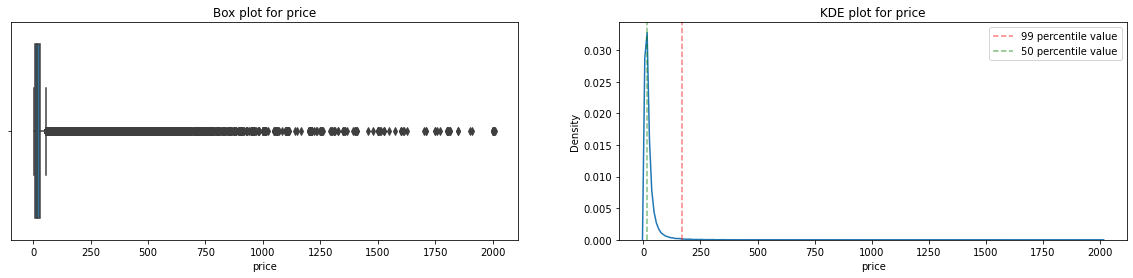

50% of the prices are below $17.0
90% of the prices are below $51.0
99% of the prices are below $170.0


In [50]:
# plotting the kde plot and box plot for price
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw,x='price')
plt.title("Box plot for price")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw,x='price')
plt.title("KDE plot for price")

# 99th %ile value
plt.axvline(raw['price'].quantile(0.99),color='red',linestyle='--',alpha=0.5,label='99 percentile value')
# 99th %ile value
plt.axvline(raw['price'].quantile(0.50),color='green',linestyle='--',alpha=0.5,label='50 percentile value')

plt.legend()
plt.show()

print(f"50% of the prices are below ${raw['price'].quantile(0.50)}")
print(f"90% of the prices are below ${raw['price'].quantile(0.90)}")
print(f"99% of the prices are below ${raw['price'].quantile(0.99)}")

>#### Observations
>- Box plot tells us the distribution is concentrated at around \\$20, and there are many outliers present
>- In the KDE plot, we can see that 99% of the values lie below \\$170
>- 1% of the values lie between \\$170 - \\$2009
>- This is a right tailed distribution, so let’s try to take log and see if it converts to normal distribution

In [51]:
# check if there is similarity in top 1%

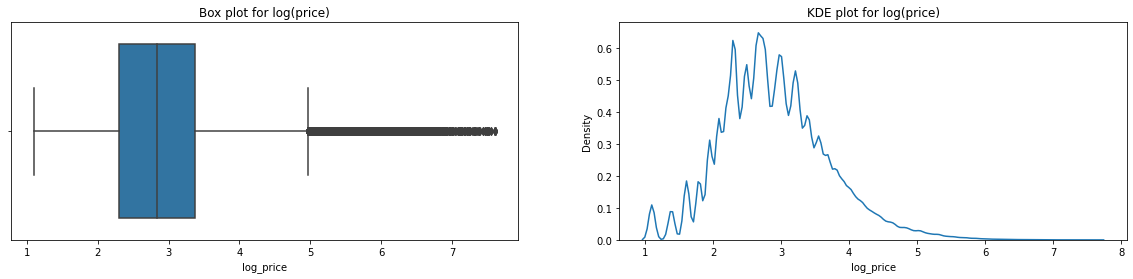

In [52]:
# plot for log(price)
raw["log_price"] = np.log(raw['price'])
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw,x='log_price')
plt.title("Box plot for log(price)")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw,x='log_price')
plt.title("KDE plot for log(price)")

plt.show()

>#### Observations
>- The plot is not normal, but the general shape is similar to a normal distribution
>- Almost all the values lie below log(price) = 6
>- The median of log(price) is ~2.8
>- 75% of the values lie below log(price) = 3.4>

### Labeling outlier values

In [53]:
# we are defining outlier as any value which is outside of +- 1.5*iqr range
iqr = raw['price'].quantile(0.75) - raw['price'].quantile(0.25)
lower_bound = max(raw['price'].quantile(0.25)-1.5*iqr,min(raw['price']))
upper_bound = min(raw['price'].quantile(0.75)+1.5*iqr,max(raw['price']))

print(f"IQR = {np.round(iqr,2)}\nLower Bound = {np.round(lower_bound,2)}\nUpper Bound = {np.round(upper_bound,2)}")

raw['is_outlier'] = np.where((raw['price']>upper_bound) | (raw['price']<lower_bound),True,False)

IQR = 19.0
Lower Bound = 3.0
Upper Bound = 57.5


### Plotting again after removing outliers

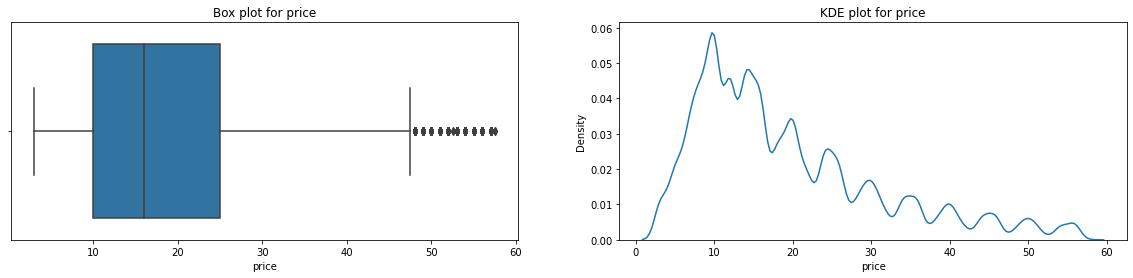

In [54]:
# plotting the kde plot and box plot for price
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw.loc[raw['is_outlier']==False],x='price')
plt.title("Box plot for price")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw.loc[raw['is_outlier']==False],x='price')
plt.title("KDE plot for price")

plt.show()

### Statistical tests to check if the distribution is normal

Setting up hypothesis to test whether the price is Gaussian distributed or not<br>
**H0**: Data is gaussian distributed<br>
**Ha**: Data is not gaussian distributed<br>
**Significance level**: 0.05 (95% confidence)

In [55]:
# function to check whether to reject or failed to reject null hypothesis
def check_hypothesis(pvalue,sig_level=0.05):
    if pvalue<sig_level:
        print(f"pvalue = {pvalue}")
        print(f"Significance level = {sig_level}")
        print("Reject the null hypothesis, accept the alternate hypothesis")
    else:
        print(f"pvalue = {pvalue}")
        print(f"Significance level = {sig_level}")
        print("Failed to reject the null hypothesis")

### 1. Q-Q Plot

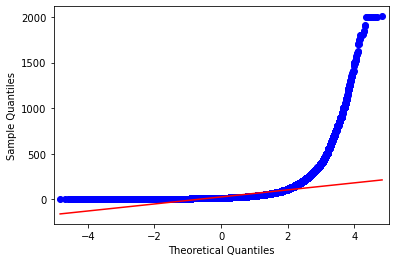

In [56]:
# price feature
qqplot(raw['price'],line='s')
plt.show()

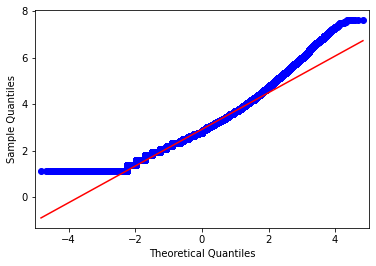

In [57]:
# log(price) feature
qqplot(raw['log_price'],line='s')
plt.show()

>#### Observations
>- The price feature is very off from normal line, hence it might not be Gaussian
>- However, log(price) is much closer to normal line

### 2. KS test

In [58]:
# price feature
mu = np.mean(raw['price'])
sigma = np.std(raw['price'])
pvalue = kstest(
    raw['price'],
    norm.cdf,
    args=(mu,sigma)
)[1]
check_hypothesis(pvalue)

pvalue = 0.0
Significance level = 0.05
Reject the null hypothesis, accept the alternate hypothesis


In [59]:
# log(price) feature
mu = np.mean(raw['log_price'])
sigma = np.std(raw['log_price'])
pvalue = kstest(
    raw['log_price'],
    norm.cdf,
    args=(mu,sigma)
)[1]
check_hypothesis(pvalue)

pvalue = 0.0
Significance level = 0.05
Reject the null hypothesis, accept the alternate hypothesis


### 3. Shapiro's test

In [60]:
# Shapiro's test does not work well for sample size > 5000
# So we sample the data 30 times, apply shapiro's test and take the mean of pvalue
# price feature
pvalue_sum = 0
for i in range(30):
    pvalue_sum += shapiro(raw['price'].sample(n=5000))[1]
check_hypothesis(pvalue_sum/30)

pvalue = 0.0
Significance level = 0.05
Reject the null hypothesis, accept the alternate hypothesis


In [61]:
# Shapiro's test does not work well for sample size > 5000
# So we sample the data 30 times, apply shapiro's test and take the mean of pvalue
# log(price) feature
pvalue_sum = 0
for i in range(30):
    pvalue_sum += shapiro(raw['log_price'].sample(n=5000))[1]
check_hypothesis(pvalue_sum/30)

pvalue = 2.9479554383960315e-23
Significance level = 0.05
Reject the null hypothesis, accept the alternate hypothesis


>#### Observations
>- All the three tests reject the hypothesis that price or log(price) are gaussian distributed. Hence, accept the alternate hypothesis that these two features are not gaussian distributed.

## Analysing category_name

In [62]:
raw['category_name'].head(10)

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
5                                    Women/Other/Other
6                             Women/Swimwear/Two-Piece
7                      Sports & Outdoors/Apparel/Girls
8                      Sports & Outdoors/Apparel/Girls
9             Vintage & Collectibles/Collectibles/Doll
Name: category_name, dtype: object

>#### Observations
>- By looking at a few values, it seems like the category is a combination of three sub-categories separated by “/“

In [63]:
# splitting category_name by "/" and analysing
temp = raw['category_name'].str.split('/',expand=True)

In [64]:
# visualizing after splitting
temp.head(2)

,0,1,2,3,4
0,Men,Tops,T-shirts,None,None
1,Electronics,Computers & Tablets,Components & Parts,None,None


In [65]:
# checking the number of rows with number of sub-categories
def num_subcategories(string):
    return len(string.split('/'))

print(raw.loc[~raw['category_name'].isna(),'category_name'].apply(num_subcategories).value_counts())

3    1470962
5       3055
4       1330
Name: category_name, dtype: int64


In [66]:
# top 10 sub-categories in splitted category_name
temp.columns = ['c1','c2','c3','c4','c5']
for c in temp.columns:
    print(f"--- Top values in {c}")
    print(f"{temp[c].value_counts().head(10)}")
    print("-"*30)

--- Top values in c1
Women                     663990
Beauty                    207725
Kids                      171555
Electronics               122632
Men                        93609
Home                       67831
Vintage & Collectibles     46519
Other                      45329
Handmade                   30835
Sports & Outdoors          25322
Name: c1, dtype: int64
------------------------------
--- Top values in c2
Athletic Apparel             134321
Makeup                       124568
Tops & Blouses               106891
Shoes                        100384
Jewelry                       61730
Toys                          58115
Cell Phones & Accessories     53273
Women's Handbags              45828
Dresses                       45730
Women's Accessories           42326
Name: c2, dtype: int64
------------------------------
--- Top values in c3
Pants, Tights, Leggings    60152
Other                      50198
Face                       50145
T-Shirts                   46349
Shoes  

>#### Observations
>- There are 5 sub-categories
>- Sub-category 4 occurs in around 4000 datapoints
>- Sub-category 5 occurs in around 3000 datapoints
>- Most frequently occurring sub-categories in c1 are related to women and beauty
>- Most frequently occurring sub-categories in c2 and c3 are related to apparel and makeup>

In [67]:
# number of unique values in c1 through c5
print("Unique values")
for c in temp.columns:
    print(f"{c}: {temp[c].nunique()}")

Unique values
c1: 10
c2: 113
c3: 870
c4: 6
c5: 2


In [68]:
# checking if there are any common values in c1 through c5
common_values = []
for c_1 in temp.columns:
    for c_2 in temp.columns:
        common_val = len(set(temp[c_1]).intersection(set(temp[c_2])))
        common_values.append([c_1,c_2,common_val])
common_values_df = pd.DataFrame(common_values,columns=['col1','col2','intersection'])

display(
    pd.crosstab(index=common_values_df['col1'],
                columns=common_values_df['col2'],
                values=common_values_df['intersection'],
                aggfunc=sum)
)

col2,c1,c2,c3,c4,c5
col1,,,,,
c1,11,3,7,1,1
c2,3,114,45,2,1
c3,7,45,871,2,1
c4,1,2,2,8,2
c5,1,1,1,2,4


In [69]:
# check if in one row of category_name is there repeated sub-categories
# for eg "Women/Other/Other"
def check_repeated(arr):
    if isinstance(arr,list):
        l1 = len(arr)
        l2 = len(set(arr))
        if l1==l2:
            return False
        else:
            return True
    else:
        return False
    
repeated_subcategory = raw['category_name'].str.split('/').apply(lambda x:check_repeated(x))
print(f"There are repeated sub-categories in {repeated_subcategory.sum()} rows")

There are repeated sub-categories in 23006 rows


In [70]:
raw.loc[repeated_subcategory,'category_name']

5                           Women/Other/Other
185                  Handmade/Jewelry/Jewelry
226                         Women/Other/Other
255                         Women/Other/Other
264                         Other/Other/Other
                          ...                
1481911                     Women/Other/Other
1482220                     Women/Other/Other
1482385    Vintage & Collectibles/Other/Other
1482402                     Women/Other/Other
1482471                     Other/Other/Other
Name: category_name, Length: 23006, dtype: object

>#### Observations
>- c3 has the highest number of unique values
>- total unique values in all sub-categories are around 1000
>- The values in all the sub-categories are not unique to position. They have some overlap.
>- One of the common keywords causing this is “other”
>- “Other” is used when some ot all of the sub-categories are not known

### Treating null values

In [71]:
# for the rows where category_name is null, check if category_name is 
# available in other rows, for the same product name
productNameNullCategory = set(raw.loc[raw['category_name'].isna(),'name'])

print("--- UNSORTED")
display(
    raw
    .loc[
        (raw['name'].isin(productNameNullCategory)) & 
        (~raw['category_name'].isna()),['name','category_name']
    ]
)
print("--- SORTED by name")
display(
    raw
    .loc[
        (raw['name'].isin(productNameNullCategory)) & 
        (~raw['category_name'].isna()),['name','category_name']
    ]
    .sort_values(by='name')
)

--- UNSORTED


,name,category_name
98,Gucci,Men/Men's Accessories/Watches
142,Sweater,Kids/Boys (4+)/Top & T-shirts
195,Black Toms,Women/Shoes/Loafers & Slip-Ons
290,Bundle,Other/Other/Other
303,Crocs,Women/Shoes/Loafers & Slip-Ons
...,...,...
1482393,Bundle,Women/Jewelry/Necklaces
1482458,bundle,"Women/Dresses/Above Knee, Mini"
1482468,American Eagle Bermuda Shorts,Women/Athletic Apparel/Shorts
1482503,Bundle!,"Women/Jeans/Slim, Skinny"


--- SORTED by name


,name,category_name
1154598,**ON HOLD**,Kids/Girls (4+)/Shoes
773361,**ON HOLD**,Handmade/Accessories/Hair
640031,**ON HOLD**,Beauty/Makeup/Face
665955,**ON HOLD**,Women/Women's Accessories/Wallets
1290337,**ON HOLD**,Kids/Boys 0-24 Mos/One-Pieces
...,...,...
655607,shirt,Women/Tops & Blouses/T-Shirts
443696,shirt,Women/Tops & Blouses/Blouse
60491,shirt,Women/Tops & Blouses/Blouse
695647,shirt,Women/Tops & Blouses/T-Shirts


>#### Observations
>- For the product names, where category_name is null, we tried to find the same product name for which the category_name is not null
>- But for many products, the name is just one worded eg- brand name, product type, product name etc.
>- Due to this, the category varies a lot. And hence we cannot fill category in this way
>- The only option is to fill “Other/Other/Other”, since we know when sub-category is not known, “Other” is present.
>- There are emojis present in some of the product names, we need to treat them

In [72]:
# the best solution is to fill the null values with "Other/Other/Other"
raw['category_name'] = raw['category_name'].fillna("Other/Other/Other")

### Preprocessing category_name for further analysis

In [73]:
# removing duplicate sub-categories from a row and converting to lower case
# for eg- "Women/Other/Other" will be converted to ['women','other'] instead of ['women','other','other']
# "Other/Other/Other" will be converted to ['other'] instead of ['other','other','other']

def remove_dup_subcat(string):
    return list(set(string.lower().split("/")))

raw['cleaned_category'] = raw['category_name'].apply(remove_dup_subcat)

In [74]:
# check if the function is working fine
# the ordering is lost, by that doesn't matter since our analysis is not dependent on ordering
raw[['category_name','cleaned_category']].head(10)

,category_name,cleaned_category
0,Men/Tops/T-shirts,"[t-shirts, tops, men]"
1,Electronics/Computers & Tablets/Components & P...,"[electronics, components & parts, computers & ..."
2,Women/Tops & Blouses/Blouse,"[blouse, tops & blouses, women]"
3,Home/Home Décor/Home Décor Accents,"[home décor accents, home décor, home]"
4,Women/Jewelry/Necklaces,"[necklaces, women, jewelry]"
5,Women/Other/Other,"[other, women]"
6,Women/Swimwear/Two-Piece,"[swimwear, two-piece, women]"
7,Sports & Outdoors/Apparel/Girls,"[apparel, sports & outdoors, girls]"
8,Sports & Outdoors/Apparel/Girls,"[apparel, sports & outdoors, girls]"
9,Vintage & Collectibles/Collectibles/Doll,"[vintage & collectibles, collectibles, doll]"


#### Exploding cleaned_category

In [75]:
categoryExploded = raw[['train_id','cleaned_category','price']].explode('cleaned_category')

In [76]:
categoryExploded.head(10)

,train_id,cleaned_category,price
0,0,t-shirts,10.0
0,0,tops,10.0
0,0,men,10.0
1,1,electronics,52.0
1,1,components & parts,52.0
1,1,computers & tablets,52.0
2,2,blouse,10.0
2,2,tops & blouses,10.0
2,2,women,10.0
3,3,home décor accents,35.0


### Visual analysis

In [77]:
# number of unique sub-categories
print(f"There are {categoryExploded['cleaned_category'].nunique()} sub-categories")

There are 949 sub-categories


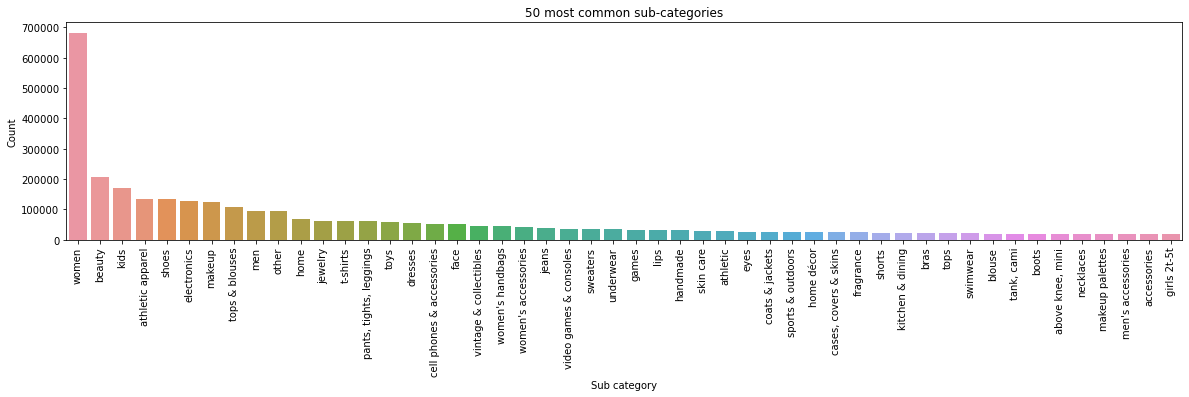

In [150]:
# 50 most common sub-categories
plt.figure(figsize=(20,4))
temp = categoryExploded['cleaned_category'].value_counts().head(50)
sns.barplot(x=temp.index,y=temp.values)
plt.xticks(rotation=90)
plt.xlabel("Sub category")
plt.ylabel("Count")
plt.title("50 most common sub-categories")
plt.show()

In [79]:
# sub-categories with highest and lowest price
highest_price = max(categoryExploded['price'])
lowest_price = min(categoryExploded.loc[categoryExploded['price']>0.0,'price'])

print(f"Sub-categories with highest price")
display(categoryExploded.loc[categoryExploded['price']==highest_price])
print(f"Sub-categories with lowest price")
display(categoryExploded.loc[categoryExploded['price']==lowest_price])

Sub-categories with highest price


,train_id,cleaned_category,price
760469,760469,women's handbags,2009.0
760469,760469,shoulder bag,2009.0
760469,760469,women,2009.0


Sub-categories with lowest price


,train_id,cleaned_category,price
88,88,vintage & collectibles,3.0
88,88,trading cards,3.0
88,88,animation,3.0
203,203,"tank, cami",3.0
203,203,tops & blouses,3.0
...,...,...,...
1482420,1482420,tops & blouses,3.0
1482420,1482420,women,3.0
1482447,1482447,makeup,3.0
1482447,1482447,eyes,3.0


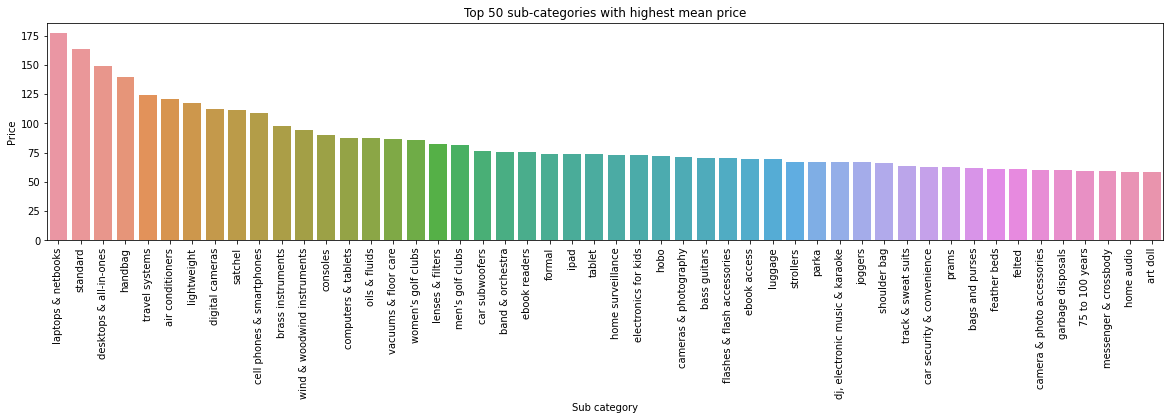

In [80]:
# subcategories with highest mean price
plt.figure(figsize=(20,4))
temp = categoryExploded.groupby('cleaned_category').agg({'price':np.mean}).reset_index().sort_values(by=['price'],ascending=False).head(50)
sns.barplot(x=temp['cleaned_category'],y=temp['price'])
plt.xticks(rotation=90)
plt.xlabel("Sub category")
plt.ylabel("Price")
plt.title("Top 50 sub-categories with highest mean price")
plt.show()

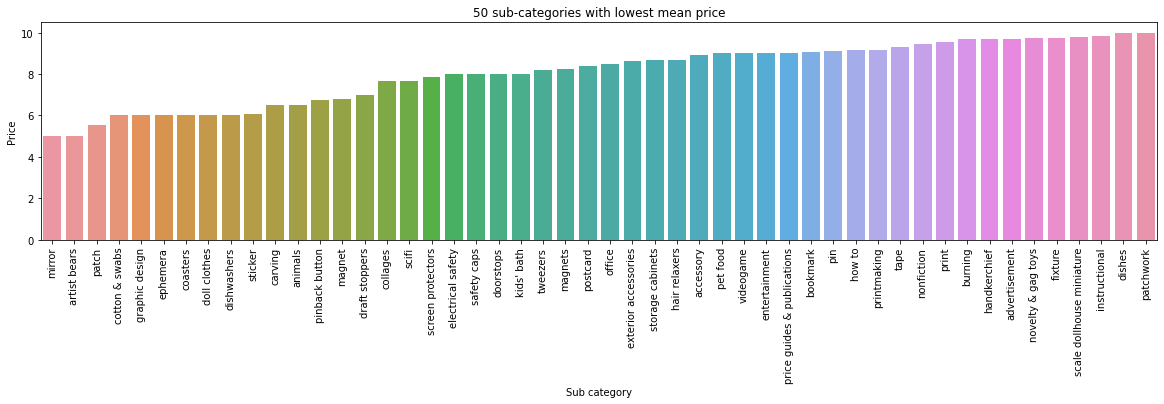

In [81]:
# subcategories with lowest mean price
plt.figure(figsize=(20,4))
temp = categoryExploded.groupby('cleaned_category').agg({'price':np.mean}).reset_index().sort_values(by=['price']).head(50)
sns.barplot(x=temp['cleaned_category'],y=temp['price'])
plt.xticks(rotation=90)
plt.xlabel("Sub category")
plt.ylabel("Price")
plt.title("50 sub-categories with lowest mean price")
plt.show()

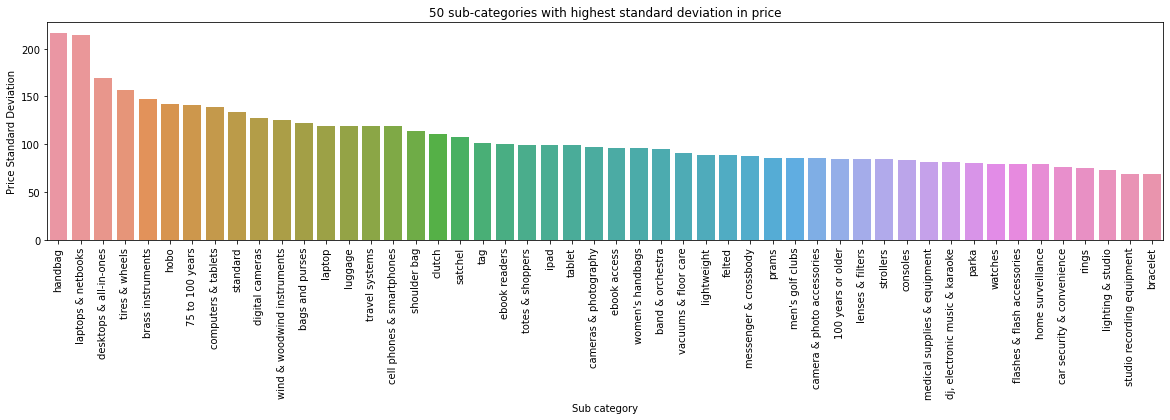

In [82]:
# subcategory with highest variability in price
plt.figure(figsize=(20,4))
temp = categoryExploded.groupby('cleaned_category').agg({'price':np.std}).reset_index().sort_values(by=['price'],ascending=False).head(50)
sns.barplot(x=temp['cleaned_category'],y=temp['price'])
plt.xticks(rotation=90)
plt.xlabel("Sub category")
plt.ylabel("Price Standard Deviation")
plt.title("50 sub-categories with highest standard deviation in price")
plt.show()

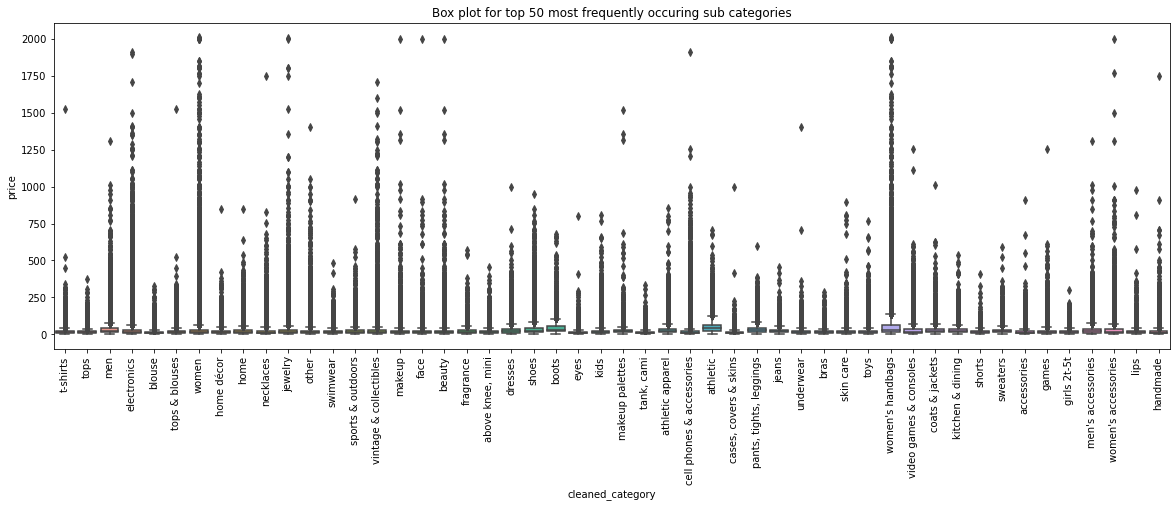

In [83]:
# box plot for top 50 most frequently occuring sub categories
plt.figure(figsize=(20,6))
temp = categoryExploded.loc[categoryExploded['cleaned_category'].isin(
    categoryExploded['cleaned_category'].value_counts().head(50).index.values),['cleaned_category','price']]
sns.boxplot(data=temp,y='price',x='cleaned_category')
plt.xticks(rotation=90)
plt.title("Box plot for top 50 most frequently occuring sub categories")
plt.show()

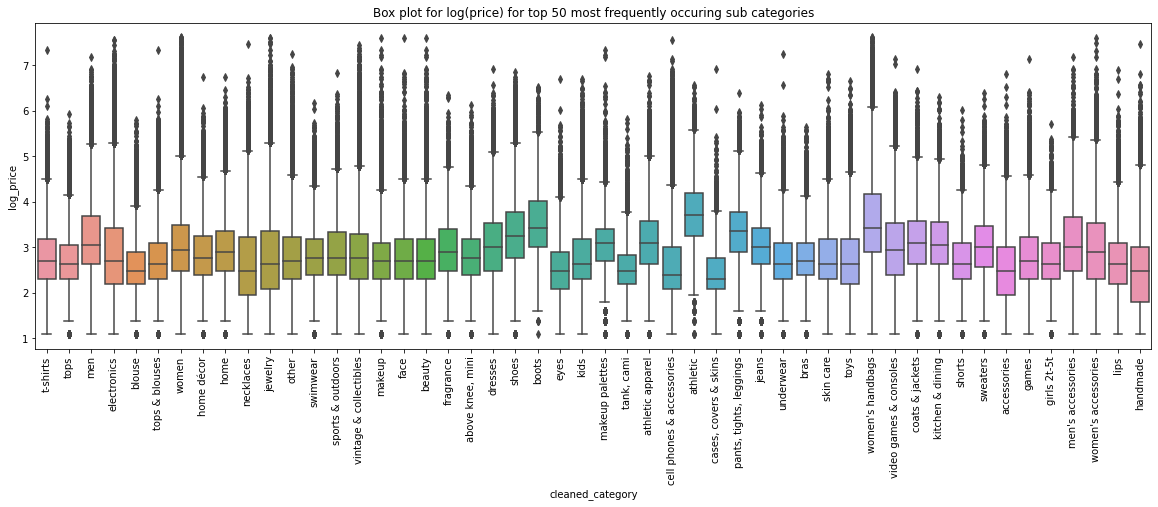

In [84]:
# box plot for log(price) for top 50 most frequently occuring sub categories
temp['log_price'] = np.log(temp['price'])
plt.figure(figsize=(20,6))
sns.boxplot(data=temp,y='log_price',x='cleaned_category')
plt.xticks(rotation=90)
plt.title("Box plot for log(price) for top 50 most frequently occuring sub categories")
plt.show()

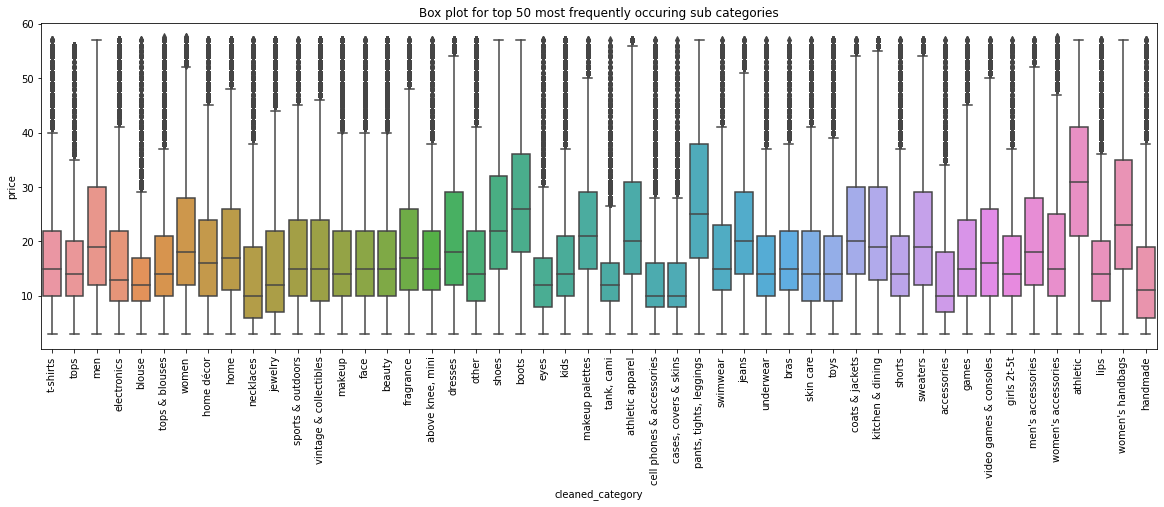

In [85]:
# after removing outliers
# box plot for top 50 most frequently occuring sub categories
plt.figure(figsize=(20,6))
temp = categoryExploded.loc[
    (categoryExploded['cleaned_category'].isin(categoryExploded['cleaned_category'].value_counts().head(50).index.values)) &
    (~raw['is_outlier']),
    ['cleaned_category','price']
]
sns.boxplot(data=temp,y='price',x='cleaned_category')
plt.xticks(rotation=90)
plt.title("Box plot for top 50 most frequently occuring sub categories")
plt.show()

>#### Observations
>- Women is the most common sub-category
>- The most expensive product in the dataset is a Women’s handbag
>- The least price in the dataset is \\$3 which belongs to many sub-categories
>- Laptops and Desktops have highest mean price
>- mirror, artist bears has the lowest mean price. These are probably same decorative items
>- Handbags, laptops, desktops and tires has the highest variations in prices
>- For the top 50 categories by frequency, we can clearly observe that log(price) varies as the category changes. So we can conclude that category affects the price of the product

## Analysing brand_name

### Null value treatment

In [87]:
# fill null values with "unknown" since it can be an indicator towards product price
raw['brand_name'] = raw['brand_name'].fillna("unknown")

### Visual Analysis

In [88]:
# number of unique brands
print(f"Number of unique brands: {raw['brand_name'].nunique()}")

Number of unique brands: 4808


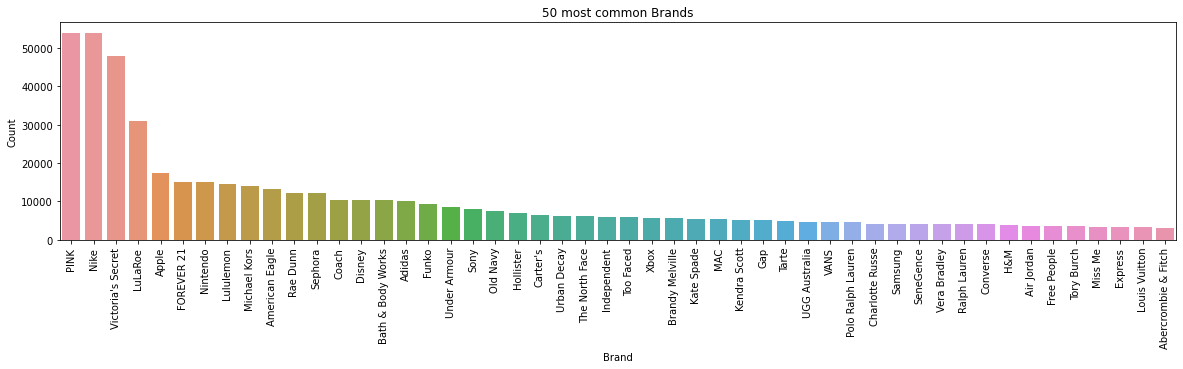

In [151]:
# most frequently occuring brands
plt.figure(figsize=(20,4))
temp = raw.loc[raw['brand_name']!='unknown','brand_name'].value_counts().head(50)
sns.barplot(x=temp.index,y=temp.values)
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Count")
plt.title("50 most common Brands")
plt.show()

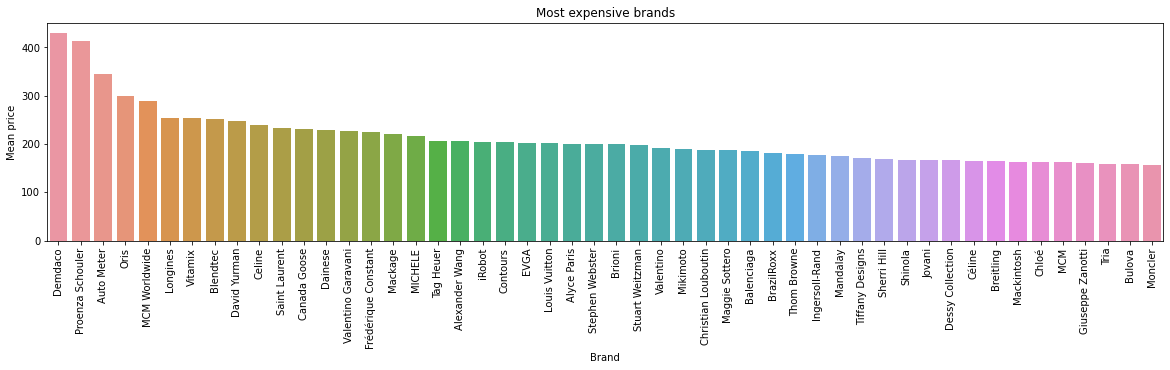

In [90]:
# most expensive brands
plt.figure(figsize=(20,4))
temp = raw.groupby('brand_name').agg({'price':np.mean}).reset_index().sort_values(by='price',ascending=False).head(50)
sns.barplot(x=temp['brand_name'],y=temp['price'])
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Mean price")
plt.title("Most expensive brands")
plt.show()

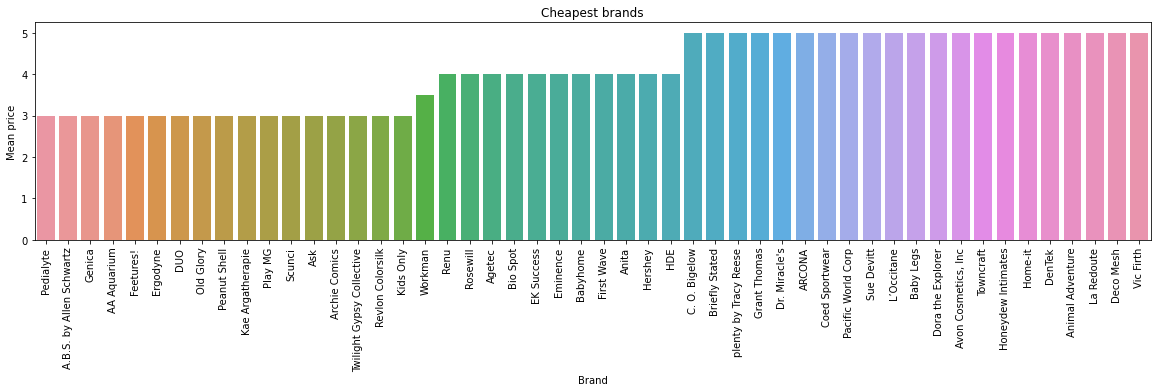

In [91]:
# cheapest brands
plt.figure(figsize=(20,4))
temp = raw.groupby('brand_name').agg({'price':np.mean}).reset_index().sort_values(by='price').head(50)
sns.barplot(x=temp['brand_name'],y=temp['price'])
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Mean price")
plt.title("Cheapest brands")
plt.show()

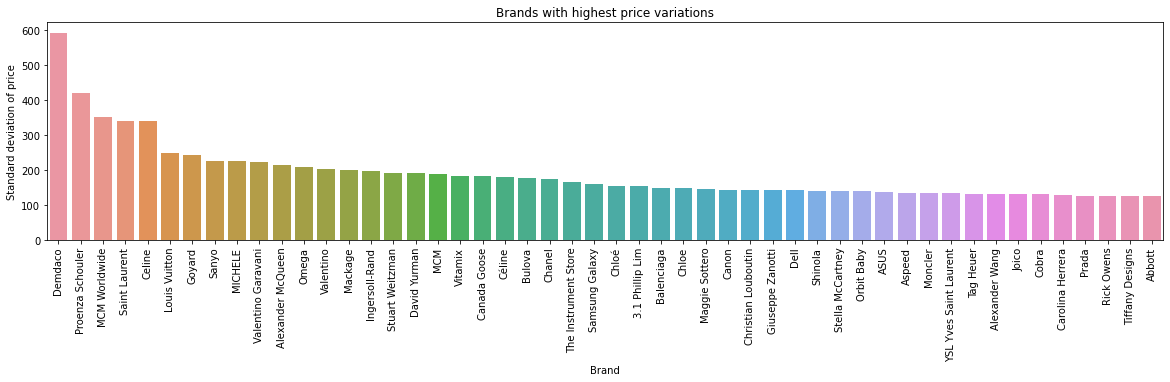

In [92]:
# brands with highest price variations
plt.figure(figsize=(20,4))
temp = raw.groupby('brand_name').agg({'price':np.std}).reset_index().sort_values(by='price',ascending=False).head(50)
sns.barplot(x=temp['brand_name'],y=temp['price'])
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Standard deviation of price")
plt.title("Brands with highest price variations")
plt.show()

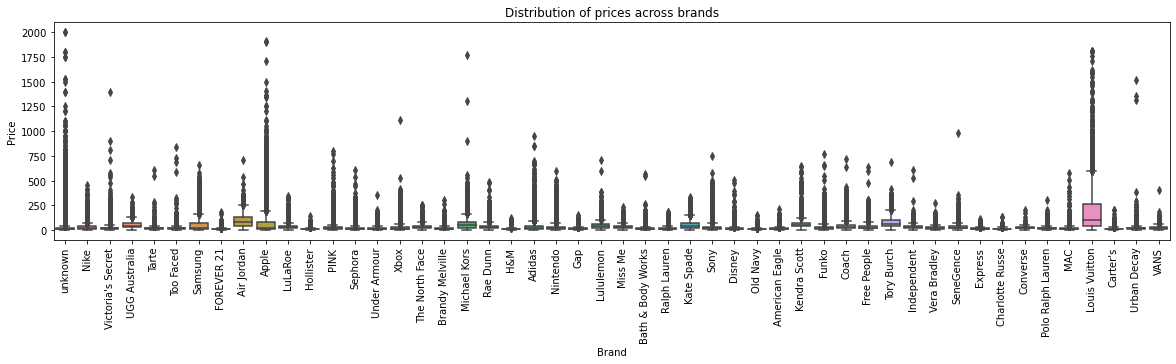

In [93]:
# box plot for brands
plt.figure(figsize=(20,4))
temp = raw.loc[raw['brand_name'].isin(
    raw['brand_name'].value_counts().head(50).index),['brand_name','price']]
sns.boxplot(data=temp,x='brand_name',y='price')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Price")
plt.title("Distribution of prices across brands")
plt.show()

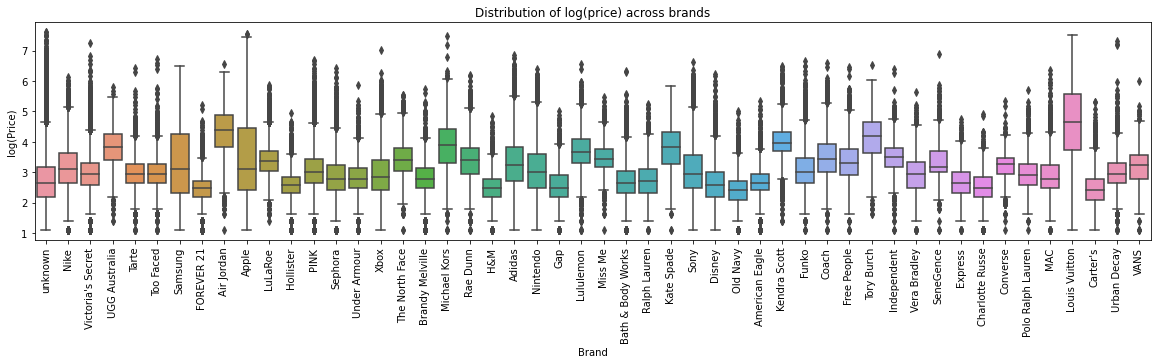

In [94]:
# box plot for log(price) for brands
plt.figure(figsize=(20,4))
temp['log_price'] = np.log(temp['price'])
sns.boxplot(data=temp,x='brand_name',y='log_price')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("log(Price)")
plt.title("Distribution of log(price) across brands")
plt.show()

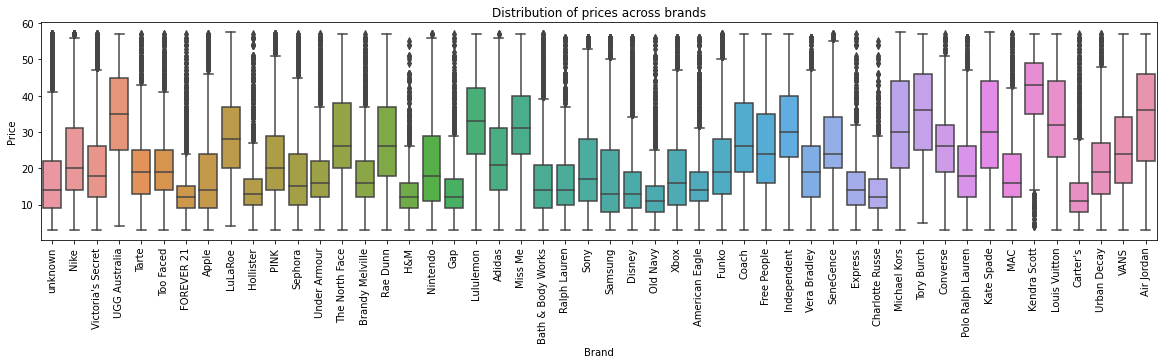

In [95]:
# after outlier removal
# box plot for brands
plt.figure(figsize=(20,4))
temp = raw.loc[
    (raw['brand_name'].isin(raw['brand_name'].value_counts().head(50).index)) &
    (~raw['is_outlier']),
    ['brand_name','price']
]
sns.boxplot(data=temp,x='brand_name',y='price')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Price")
plt.title("Distribution of prices across brands")
plt.show()

>#### Observations
>- PINK, Nike and Victoria’s Secret are most frequently occurring brands
>- Demdaco, Proenza, Auto Meter and Oris are the most expensive brands
>- Demdaco Proenza Schouler are the brands with highest price variations
>- Box plot of price for different brands is not readable
>- Box plot of log(price) clearly indicates that there is a variation in prices across brands
>- We can infer that brand might be a good indicator for prediction the product price

## Analysing item_description

### Null value treatment

In [96]:
# fill "No description yet" where values are null
raw['item_description'] = raw['item_description'].fillna("No description yet")

### Preprocessing text in description for analysis

In [97]:
stop_words = set(stopwords.words("english"))
def preprocess_description(string):
    string = string.lower() # convert to lower case
    string = re.sub("\[rm\]","",string) # remove "[rm]" from string
    string = re.sub("[^A-Za-z0-9]+"," ",string) # remove special characters
    string = re.sub("\w*\d+\w*"," ",string)
    string = re.sub("\s{2,}"," ",string).strip() # remove extra spaces
    string = " ".join([word for word in string.split() if word not in stop_words]) #removing stopwords
    return string

In [153]:
# visualizing before and after preprocessing
print(raw['item_description'].iloc[215])
print("-"*30)
print(preprocess_description(raw['item_description'].iloc[215]))

KATE SPADE Glitter Bug Wristlet Rose Gold Multi iPhone 5 6 7 Case Purse Bag NWT Kate Spade New York wristlet in Rose Gold Glitter PVC and logo lettering on the front. A snap opens the top flap, and the trifold interior holds 4 card slots, an ID slot, a bill pocket, a mirror, and a wide iPhone 6 pocket. Wrist strap. Rose gold glitter PVC Leather interior Fits iPhone 5, 6 and 7 but not plus sizes Measurements Width: 3.75in / 9.5cm Length: 6in / 15.5cm Brand new and 100% authentic. Shipped immediately from a smoke free home.
------------------------------
kate spade glitter bug wristlet rose gold multi iphone case purse bag nwt kate spade new york wristlet rose gold glitter pvc logo lettering front snap opens top flap trifold interior holds card slots id slot bill pocket mirror wide iphone pocket wrist strap rose gold glitter pvc leather interior fits iphone plus sizes measurements width length brand new authentic shipped immediately smoke free home


In [99]:
# No description yet --> description yet after stopwords removal
preprocess_description(raw['item_description'].iloc[214])

'description yet'

In [100]:
# applying preprocessing
raw['cleaned_description'] = raw['item_description'].apply(preprocess_description)

### Word frequencies and impact on price

In [101]:
# here we will calculated, for each word in descriptions, what is it's frequency and what impact it has on price
# for price impact
# 1. we will sum up all the values of price where the work has occured
# 2. divide the price sum by the word frequency to get mean price
# this will give us the mean price where this word is used.

In [102]:
word_freq = dict() # dictionary to contain all the words, their frequency and sum of prices they occur in

# for each description, we will take the word in it, update their frequence, and add to the sum of price
for index,row in raw.iterrows():
    desc = set(row['cleaned_description'].split())
    for word in desc:
        d = word_freq.get(word,{'freq':0,'price_sum':0})
        d['freq'] += 1
        d['price_sum'] += row['price']/1000
        word_freq[word] = d

In [103]:
# calculating count of frequency of words
word_frequencies = [d['freq'] for d in word_freq.values()]
word_frequencies = pd.value_counts(word_frequencies)

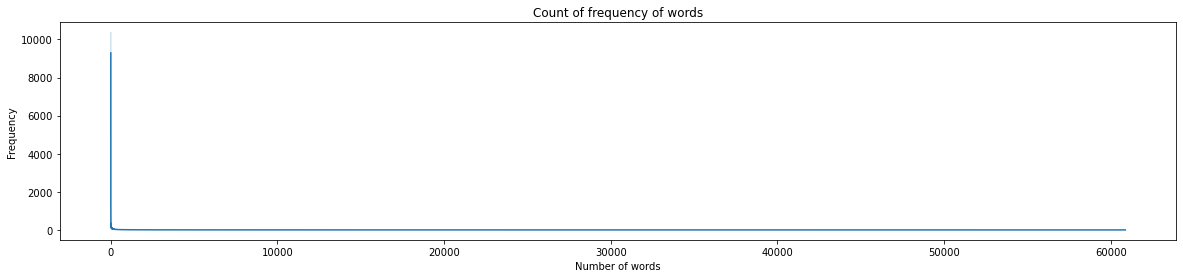

In [154]:
# plotting count of frequency of words
plt.figure(figsize=(20,4))
sns.lineplot(x=word_frequencies.values,y=word_frequencies.index)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Count of frequency of words")
plt.show()

In [105]:
# top 15 most used keywords
sorted({k:v['freq'] for k,v in word_freq.items()}.items(),key=lambda x:x[1],reverse=True)[:15]

[('new', 459351),
 ('size', 393101),
 ('brand', 259227),
 ('condition', 245500),
 ('free', 223229),
 ('shipping', 188244),
 ('worn', 180801),
 ('used', 170589),
 ('never', 152613),
 ('great', 142327),
 ('price', 136123),
 ('black', 135357),
 ('bundle', 112929),
 ('like', 105881),
 ('small', 105766)]

In [106]:
# top 15 least used keywords
sorted({k:v['freq'] for k,v in word_freq.items()}.items(),key=lambda x:x[1],reverse=True)[-1:-15:-1]

[('proctector', 1),
 ('idfwu', 1),
 ('druddigon', 1),
 ('lileep', 1),
 ('manectric', 1),
 ('avalugg', 1),
 ('spheal', 1),
 ('sawk', 1),
 ('chatot', 1),
 ('honedge', 1),
 ('pyroar', 1),
 ('simisage', 1),
 ('tynamo', 1),
 ('litleo', 1)]

In [157]:
# top 15 most expensive keywords
sorted({k:np.round(v['price_sum']*1000/v['freq'],1) for k,v in word_freq.items() if v['freq']>10}.items(),key=lambda x:x[1],reverse=True)[:15]

[('bandouliere', 855.8),
 ('appraisal', 688.9),
 ('ballerine', 491.9),
 ('wheaton', 454.8),
 ('tradesy', 445.2),
 ('applecare', 432.8),
 ('ebene', 403.9),
 ('layaway', 386.1),
 ('ssd', 378.8),
 ('tivoli', 376.1),
 ('macos', 360.7),
 ('lambskin', 347.7),
 ('anya', 344.5),
 ('neverfull', 340.1),
 ('ilife', 333.7)]

In [158]:
# top 15 cheapest keywords
sorted({k:np.round(v['price_sum']*1000/v['freq'],2) for k,v in word_freq.items() if v['freq']>10}.items(),key=lambda x:x[1],reverse=True)[-1:-15:-1]

[('calabash', 3.25),
 ('shopwithclass', 3.42),
 ('jaymo', 3.53),
 ('reuploading', 3.75),
 ('farmlands', 3.8),
 ('kdrama', 4.0),
 ('venasuar', 4.08),
 ('stitchwork', 4.19),
 ('sewon', 4.19),
 ('wipis', 4.24),
 ('chaffed', 4.36),
 ('oouch', 4.59),
 ('vlp', 4.65),
 ('tactually', 4.67)]

### Generating word cloud 

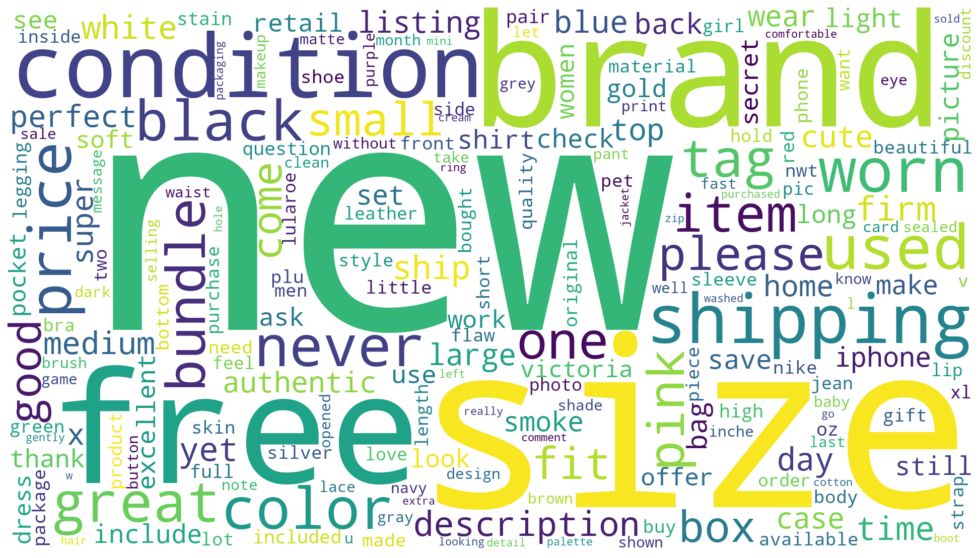

In [109]:
text = " ".join(desc for desc in raw['cleaned_description'])
wc = WordCloud(collocations=False,width=1920,height=1080,background_color='white').generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

>#### Observations
>- new, size, brand, free shipping, description yet (means the description is missing), great condition are some of the most frequently used words
>- proctector (misspelled for protector), chatot (misspelled for chatbot) are some of the least used words
>- asistant (misspelled for assistant), lightly are some of the words used in the description of expensive products
>- polybutylene, aplogize (misspelled for apologise) are some of words used in description of cheapest products

### Extracting features from description

#### Length of description

In [110]:
raw['description_length'] = raw['item_description'].apply(len)

#### Words in description

In [111]:
raw['description_word_count'] = raw['item_description'].apply(lambda x:len(x.split()))

### Analysing extracted features

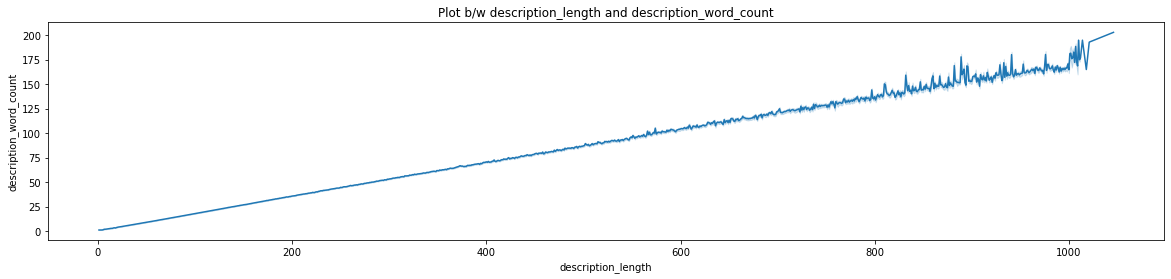

In [112]:
# plotting these two features
plt.figure(figsize=(20,4))
sorted_raw = raw.sort_values(by='description_length')[['description_length','description_word_count']]
sns.lineplot(data=sorted_raw,x='description_length',y='description_word_count')
plt.title("Plot b/w description_length and description_word_count")
plt.show()

In [113]:
print(f"Pearson correlation coefficient between description length and description word count = {np.round(np.corrcoef(raw['description_length'],raw['description_word_count'])[1][0],2)}")

Pearson correlation coefficient between description length and description word count = 0.99


In [114]:
print(f"Spearman rank correlation coefficient between description length and description word count = {np.round(spearmanr(raw['description_length'],raw['description_word_count'])[0],2)}")

Spearman rank correlation coefficient between description length and description word count = 0.99


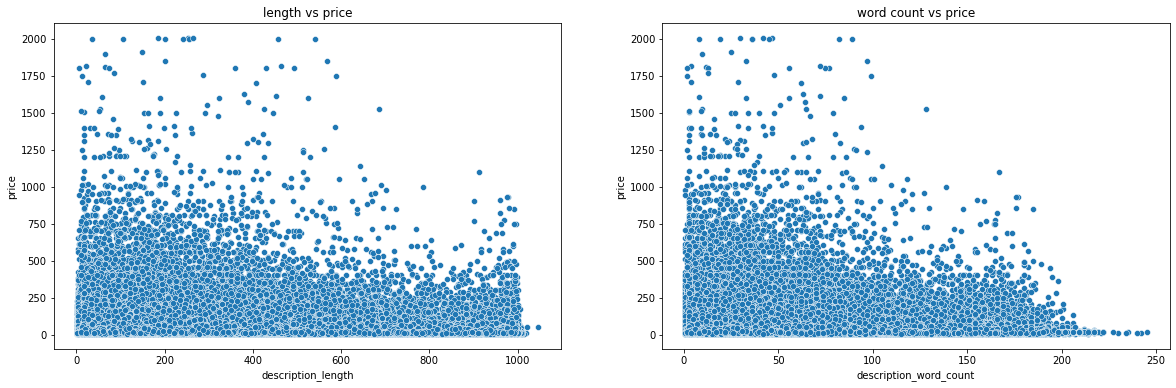

In [115]:
# scatter plot between extracted features and price
plt.figure(figsize=(20,6))

# length
plt.subplot(1,2,1)
sns.scatterplot(raw['description_length'],raw['price'])
plt.title("length vs price")

# word count
plt.subplot(1,2,2)
sns.scatterplot(raw['description_word_count'],raw['price'])
plt.title("word count vs price")

plt.show()

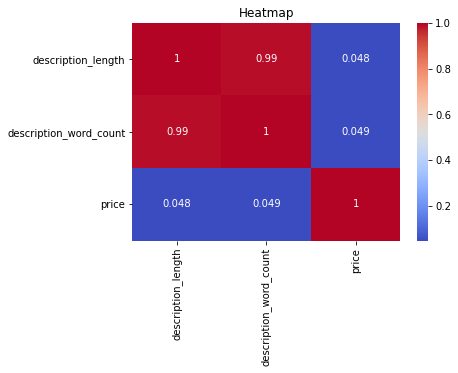

In [116]:
plt.figure(figsize=(6,4))
sns.heatmap(raw[['description_length','description_word_count','price']].corr(),cmap='coolwarm',annot=True)
plt.title("Heatmap")
plt.show()

In [117]:
# spearman rank correlation coefficient (SRCC)
print(f"SRCC for description_length and price = {np.round(spearmanr(raw['description_length'],raw['price'])[0],2)}")
print(f"SRCC for description_word_count and price = {np.round(spearmanr(raw['description_word_count'],raw['price'])[0],2)}")

SRCC for description_length and price = 0.07
SRCC for description_word_count and price = 0.07


>#### Observations
>- The length of description and count of word in description are strongly positively correlated
>- However, both these features do not have an impact on product price

## Analysing item_condition_id

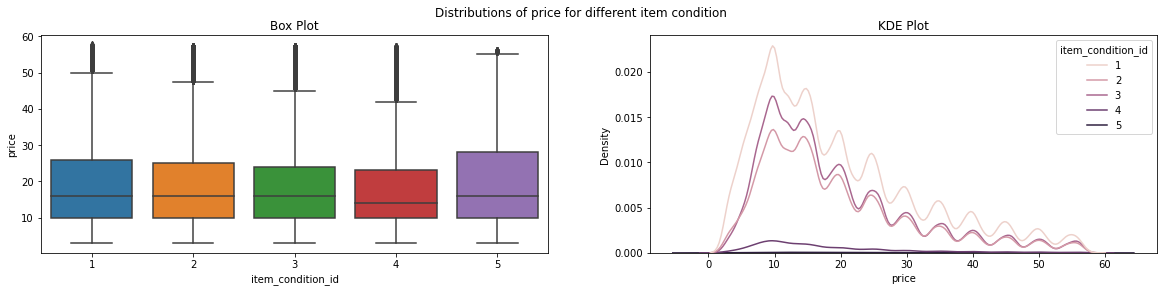

In [118]:
# box plot for differnt item conditions
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw.loc[raw['is_outlier']==False],x='item_condition_id',y='price')
plt.title("Box Plot")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw.loc[raw['is_outlier']==False],x='price',hue='item_condition_id')
plt.title("KDE Plot")

plt.suptitle("Distributions of price for different item condition")
plt.show()

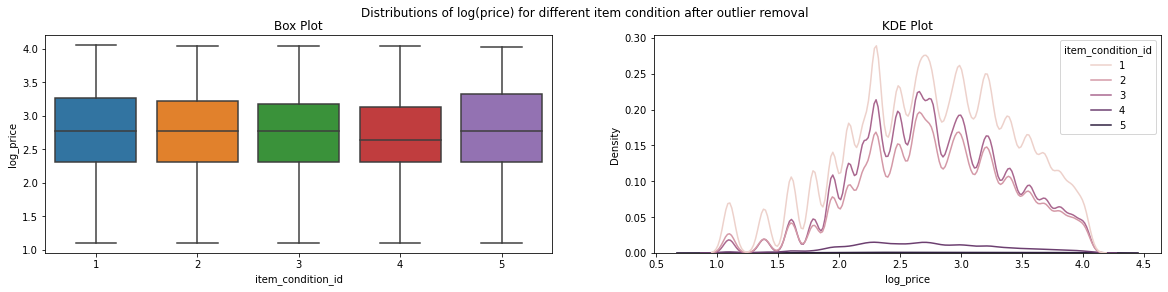

In [119]:
# box plot for log(price) for differnt item conditions
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw.loc[raw['is_outlier']==False],x='item_condition_id',y='log_price')
plt.title("Box Plot")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw.loc[raw['is_outlier']==False],x='log_price',hue='item_condition_id')
plt.title("KDE Plot")

plt.suptitle("Distributions of log(price) for different item condition after outlier removal")
plt.show()

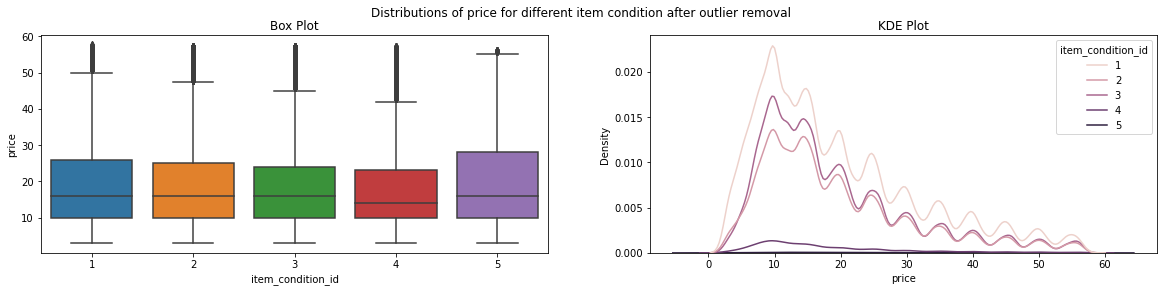

In [120]:
# after removing outliers
# box plot for differnt item conditions
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw.loc[raw['is_outlier']==False],x='item_condition_id',y='price')
plt.title("Box Plot")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw.loc[raw['is_outlier']==False],x='price',hue='item_condition_id')
plt.title("KDE Plot")

plt.suptitle("Distributions of price for different item condition after outlier removal")
plt.show()

>#### Observations
>- IQR of item_condition = 4 is the lowest, and that of item_condition = 5 is the highest
>- There is a high overlap in the distributions

## Analysing shipping

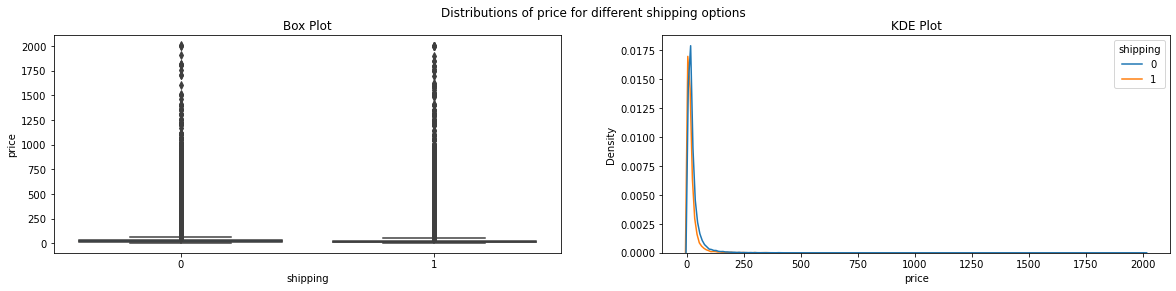

In [121]:
# box plot for differnt shipping options
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw,x='shipping',y='price')
plt.title("Box Plot")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw,x='price',hue='shipping')
plt.title("KDE Plot")

plt.suptitle("Distributions of price for different shipping options")
plt.show()

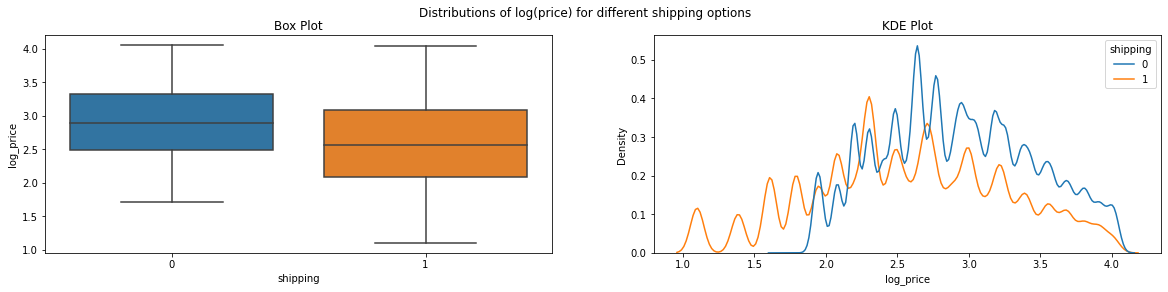

In [122]:
# distribution of log(price) for differnt shipping options
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw.loc[raw['is_outlier']==False],x='shipping',y='log_price')
plt.title("Box Plot")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw.loc[raw['is_outlier']==False],x='log_price',hue='shipping')
plt.title("KDE Plot")

plt.suptitle("Distributions of log(price) for different shipping options")
plt.show()

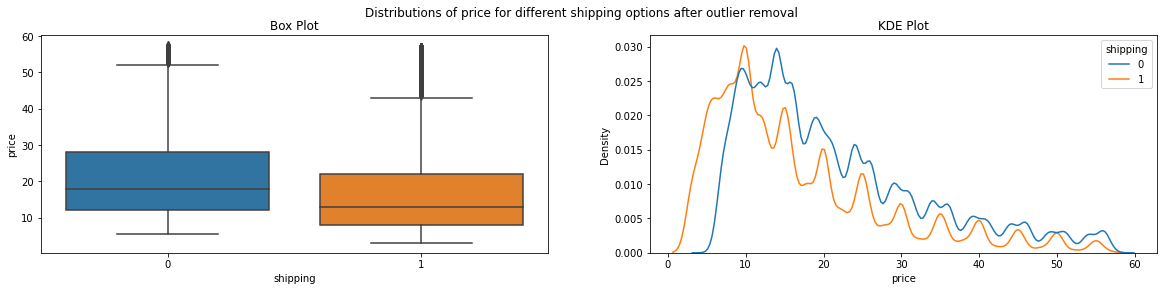

In [123]:
# after removing outliers
# distribution for differnt shipping options
plt.figure(figsize=(20,4))

# box plot
plt.subplot(1,2,1)
sns.boxplot(data=raw.loc[raw['is_outlier']==False],x='shipping',y='price')
plt.title("Box Plot")

# kde plot
plt.subplot(1,2,2)
sns.kdeplot(data=raw.loc[raw['is_outlier']==False],x='price',hue='shipping')
plt.title("KDE Plot")

plt.suptitle("Distributions of price for different shipping options after outlier removal")
plt.show()

>#### Observations
>- The price is slightly higher when shipping = 0 compared to shipping = 1
>- Still there is a high overlap in the distributions

## Analysing name

### Preprocessing text in product name for analysis

In [159]:
# visualizing after preprocessing
print(raw['name'].iloc[215])
print("-"*30)
print(preprocess_description(raw['name'].iloc[215]))

Kate Spade Glitter Bug Wristlet NEW
------------------------------
kate spade glitter bug wristlet new


In [125]:
# applying preprocessing
raw['cleaned_name'] = raw['name'].apply(preprocess_description)

### Word frequencies and impact on price

In [126]:
# this step is similar to what we did with description

In [127]:
word_freq_name = dict() # dictionary to contain all the words, their frequency and sum of prices they occur in

# for each name, we will take the word in it, update their frequency, and add to the sum of price
for index,row in raw.iterrows():
    desc = set(row['cleaned_name'].split())
    for word in desc:
        d = word_freq_name.get(word,{'freq':0,'price_sum':0})
        d['freq'] += 1
        d['price_sum'] += row['price']/1000
        word_freq_name[word] = d

In [128]:
# calculating count of frequencies of words
word_frequencies_name = [d['freq'] for d in word_freq_name.values()]
word_frequencies_name = pd.value_counts(word_frequencies_name)

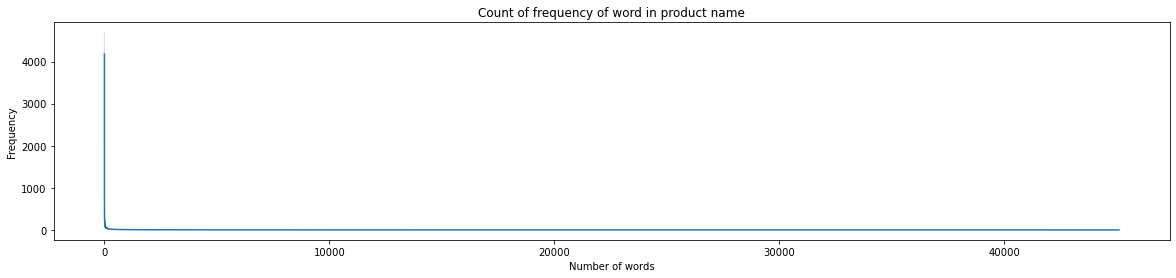

In [160]:
# plotting count of frequencies of words
plt.figure(figsize=(20,4))
sns.lineplot(x=word_frequencies_name.values,y=word_frequencies_name.index)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title("Count of frequency of word in product name")
plt.show()

In [130]:
# top 15 most used keywords
sorted({k:v['freq'] for k,v in word_freq_name.items()}.items(),key=lambda x:x[1],reverse=True)[:15]

[('pink', 83344),
 ('bundle', 77744),
 ('new', 76614),
 ('size', 73029),
 ('lularoe', 63407),
 ('black', 56185),
 ('nike', 46346),
 ('vs', 44306),
 ('secret', 40501),
 ('dress', 39234),
 ('victoria', 39116),
 ('leggings', 38831),
 ('shirt', 38646),
 ('nwt', 38344),
 ('free', 37428)]

In [131]:
# top 15 least used keywords
sorted({k:v['freq'] for k,v in word_freq_name.items()}.items(),key=lambda x:x[1],reverse=True)[-1:-15:-1]

[('markets', 1),
 ('bespa', 1),
 ('lebongirl', 1),
 ('bellora', 1),
 ('shirly', 1),
 ('shuckle', 1),
 ('andirons', 1),
 ('pebbleatom', 1),
 ('fanomenal', 1),
 ('hatterdashers', 1),
 ('wedger', 1),
 ('vercace', 1),
 ('perfumev', 1),
 ('dusr', 1)]

In [161]:
# top 15 most expensive keywords
sorted({k:np.round(v['price_sum']*1000/v['freq'],2) for k,v in word_freq_name.items() if v['freq']>10}.items(),key=lambda x:x[1],reverse=True)[:15]

[('delightful', 776.33),
 ('bandouliere', 688.19),
 ('woc', 683.33),
 ('ballerine', 536.0),
 ('inr', 494.5),
 ('felicie', 491.69),
 ('neverful', 459.53),
 ('neverfull', 388.04),
 ('azur', 378.65),
 ('ebene', 375.06),
 ('cabas', 370.29),
 ('keepall', 361.93),
 ('tivoli', 361.63),
 ('gm', 360.86),
 ('retina', 343.56)]

In [162]:
# top 15 cheapest keywords
sorted({k:np.round(v['price_sum']*1000/v['freq'],2) for k,v in word_freq_name.items() if v['freq']>10}.items(),key=lambda x:x[1],reverse=True)[-1:-15:-1]

[('amount', 3.8),
 ('fakee', 4.12),
 ('eyecat', 4.21),
 ('wipis', 4.25),
 ('nicka', 5.21),
 ('lightbar', 5.23),
 ('stent', 5.32),
 ('blistex', 5.38),
 ('popclick', 5.47),
 ('refractor', 5.59),
 ('seraphine', 5.64),
 ('thumbstick', 5.69),
 ('nose', 5.69),
 ('legavenue', 5.73)]

### Generating word cloud 

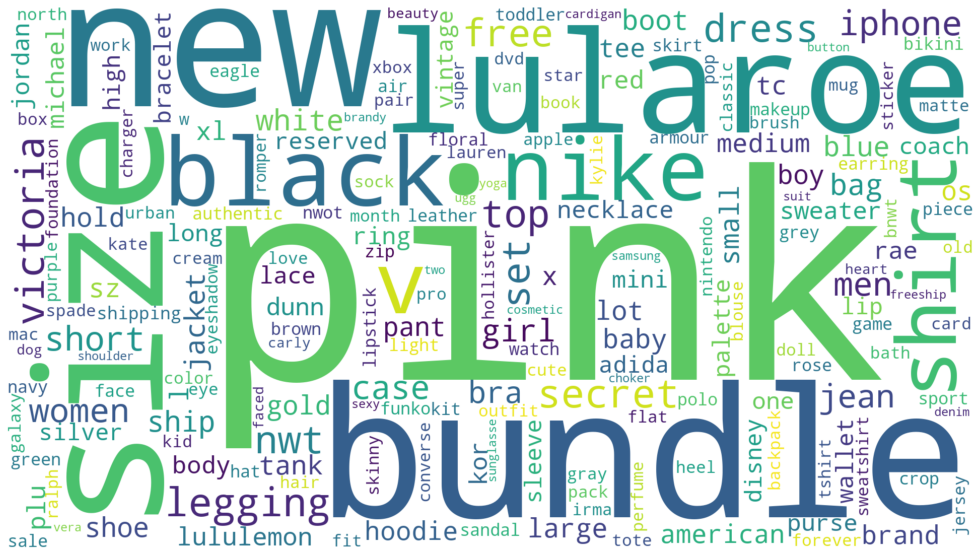

In [134]:
text_name = " ".join(desc for desc in raw['cleaned_name'])
wc_name = WordCloud(collocations=False,width=1920,height=1080,background_color='white').generate(text_name)
plt.figure(figsize=(20,10))
plt.imshow(wc_name,interpolation='bilinear')
plt.axis('off')
plt.savefig('plots/wordcloud_name.png')
plt.show()

>#### Observations
>- pink, bundle, new, size are some of the most frequently occurring words in product name
>- markets, bespa, lebongirl are some of the least used words in the product name
>- delightful, woc, ballerine are some of the words used in product name of most expensive products
>- amount, fakee (misspelled for fake), eyecat are some of the words used in product names of cheapest products

### Extracting features from product name

#### Length of name

In [135]:
raw['name_length'] = raw['name'].apply(len)

#### Words in product name

In [136]:
raw['name_word_count'] = raw['name'].apply(lambda x:len(x.split()))

### Analysing extracted features

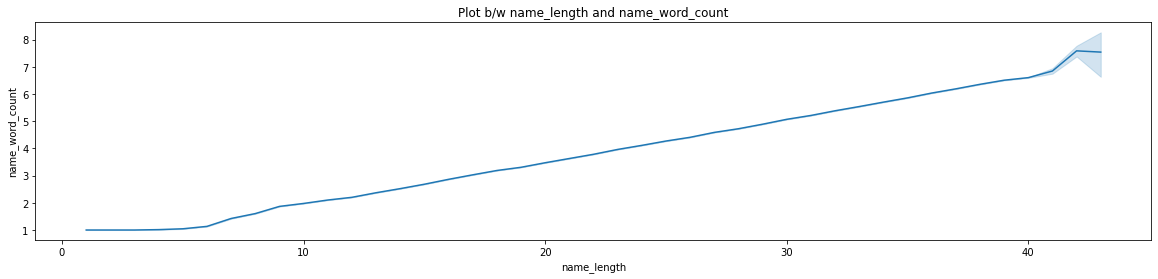

In [137]:
# plotting these two features
plt.figure(figsize=(20,4))
sorted_raw = raw.sort_values(by='name_length')[['name_length','name_word_count']]
sns.lineplot(data=sorted_raw,x='name_length',y='name_word_count')
plt.title("Plot b/w name_length and name_word_count")
plt.show()

In [138]:
print(f"Pearson correlation coefficient between name length and name word count = {np.round(np.corrcoef(raw['name_length'],raw['name_word_count'])[1][0],2)}")

Pearson correlation coefficient between name length and name word count = 0.88


In [139]:
print(f"Spearman rank correlation coefficient between name length and name word count = {np.round(spearmanr(raw['name_length'],raw['name_word_count'])[0],2)}")

Spearman rank correlation coefficient between name length and name word count = 0.88


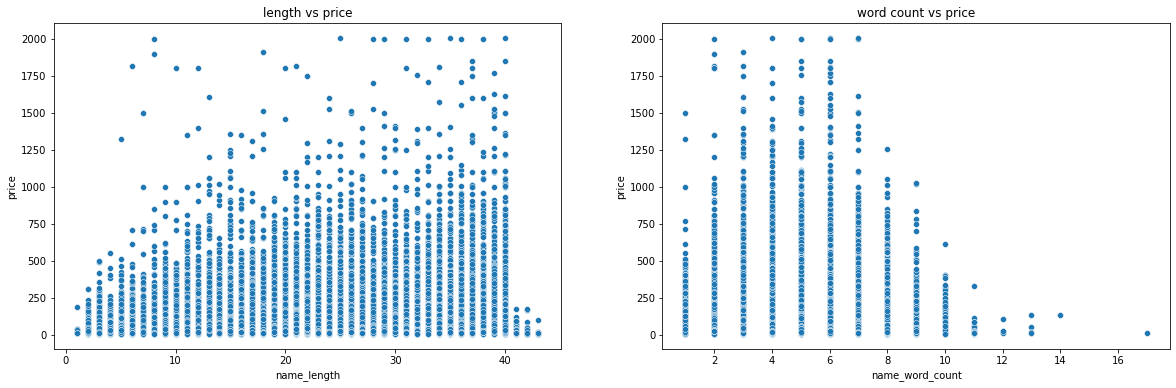

In [140]:
# scatter plot between extracted features and price
plt.figure(figsize=(20,6))

# length
plt.subplot(1,2,1)
sns.scatterplot(raw['name_length'],raw['price'])
plt.title("length vs price")

# word count
plt.subplot(1,2,2)
sns.scatterplot(raw['name_word_count'],raw['price'])
plt.title("word count vs price")

plt.show()

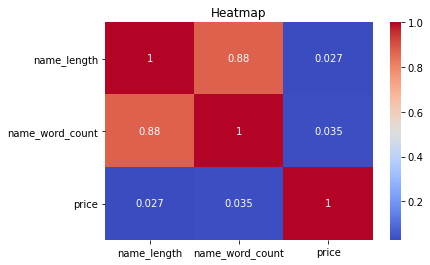

In [141]:
plt.figure(figsize=(6,4))
sns.heatmap(raw[['name_length','name_word_count','price']].corr(),cmap='coolwarm',annot=True)
plt.title("Heatmap")
plt.show()

In [142]:
# spearman rank correlation coefficient (SRCC)
print(f"SRCC for description_length and price = {np.round(spearmanr(raw['name_length'],raw['price'])[0],2)}")
print(f"SRCC for description_word_count and price = {np.round(spearmanr(raw['name_word_count'],raw['price'])[0],2)}")

SRCC for description_length and price = 0.05
SRCC for description_word_count and price = 0.05


>#### Observations
>- The length of description and count of word in description are strongly positively correlated
>- However, both these features do not have an impact on product price

# Conclusion

- In this notebook, we understood what Mercari is, what it does and what is the objective of this case study. In brief, we have a product price recommendation dataset which we wanted to analyse, in terms of product price and the features affecting it.<br>
- We had two text-based columns viz. name and item_description. We used preprocessing techniques to clean these texts. Further, we analysed the impact of different words on the price and concluded that the presence or absence of certain words does impact the price of the product, and hence these features are important for predicting the price.<br>
- We also analysed the category_name column, which was a combination of multiple sub-categories. We explored multiple ways of featurizing this column and the impact of different sub-categories on the price. Post which we concluded that this feature has a strong impact on price.<br>
- Brand name is one of the most important features in this dataset as the price is highly dependent on it. We analysed the distribution of prices for different brands and saw that this is indeed correct.<br>
- Shipping mode and item condition were weakly related to the price, though they might be very useful when we use them in combination with other features.<br>
- At last, we extracted some features related to text columns viz. product name and description. Though we saw a strong correlation between the extracted features, they were not related to the price in any manner, and hence cannot be used in predicting the product price.<br>